In [1]:
# Voeg imports toe als je ze nodig hebt
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt

%matplotlib inline 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder 
from torchvision.transforms import ToTensor
import torch.nn as nn

In [2]:
#resize all the images in folder and subfolders ./apple_disease_classification/

import os

from PIL import Image

for subdir, dirs, files in os.walk('./apple_disease_classification/'):
    for file in files:
        filepath = subdir + os.sep + file

        if filepath.endswith(".jpg") or filepath.endswith(".jpeg"): #to-do pre-check for all image filetypes
            img = Image.open(filepath)
            rgb_im = img.convert('RGB') #had to delete one because the jpg was not parseable somehow, blotch #17 is png ipv jpg look into it later
            rgb_im_resized = rgb_im.resize((128,128))
            rgb_im_resized.save(filepath)



In [3]:
dataset_path = "./apple_disease_classification/Train"
transform = ToTensor()
dataset = ImageFolder(dataset_path, transform=transform)

In [4]:
dataset.class_to_idx

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [5]:
#split in train and test 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [6]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) #numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False) #no need to shuffle when evaluating

In [7]:
#-------------------------------------------------------
import torch.nn.functional as F
class CNN(nn.Module):
    
    #-------------------------------------------------------
    
    def __init__(self):
        
        # Because we inherit from Module base class
        super().__init__()
        
        # RGB input, 6 filters, kernel of 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)  #initialise convolution but not execute
        
        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)
        
        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layer matched on output of conv2 layer
        self.fc1 = nn.Linear(16 * 29 * 29, 120) # (64-5+1 = 60/2(pool) = 30-5+1 = 26/2 = 13)
        
        # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # We have 10 labels
        self.fc3 = nn.Linear(84, 4)

        # initialize dropout of 20%
        self.drop1 = nn.Dropout(p=0.2)
        
    #-------------------------------------------------------
    def forward(self, x):
        
        # Convolution with relu layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)

        #### RuntimeError: shape '[-1, 400]' is invalid for input of size 173056 (x.shape = torch.Size([64, 16, 13, 13]) )
        #### print('x.shape after pool-relu-conv2:', x.shape) = x.shape after pool-relu-conv2: torch.Size([64, 16, 13, 13])

        x = x.view(-1, 16 * 29 * 29)
        # Transfer from convolution to classification part:
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        
        # No activation on final layer 
        return self.fc3(x)

#-------------------------------------------------------

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [9]:
myCNN = CNN().to(device)

import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN.parameters(),lr=0.01,momentum=0.9)
epochs = 35

In [10]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images[1].shape

torch.Size([3, 128, 128])

<Figure size 640x480 with 0 Axes>

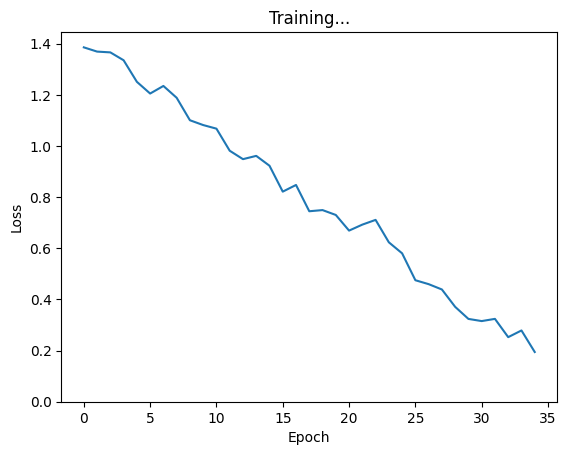

In [132]:
# Train function

from realtime_graph import realtimeplot
import gc

epochresults = []

for epoch in range(epochs):
    
    running_loss = 0.0

    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        #-------------------------
        
        #forward pass
        outputs = myCNN.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        #memory management: free up space
        del inputs, labels, outputs 
        torch.cuda.empty_cache()
        gc.collect()

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epochresults.append(epoch_loss)

    realtimeplot(epochresults)

In [133]:
#maybe from around epoch 35-40 overfitting

In [134]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(testloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        #-------------------------
        
        # calculate outputs by running images through the network
        outputs = myCNN.forward (inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the Validation images: {100 * correct // total} %')

Accuracy of the network on the Validation images: 72 %


In [135]:
dataset_path_test = "./apple_disease_classification/Test"
transform = ToTensor()
dataset_test = ImageFolder(dataset_path, transform=transform)
dataset_test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

In [136]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        #-------------------------
        
        # calculate outputs by running images through the network
        outputs = myCNN.forward (inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 89 %


In [137]:
resnetmodel = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
num_ftrs = resnetmodel.fc.in_features

# Here the size of each output sample is set to 4
resnetmodel.fc = nn.Linear(num_ftrs, 4)

# Check if output size is correct
resnetmodel.eval()

Using cache found in C:\Users\tinke/.cache\torch\hub\pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [138]:
#load to CUDA
myresnetmodel = resnetmodel.to(device)

In [139]:
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myresnetmodel.parameters(),lr=0.001,momentum=0.9)
epochs = 15

<Figure size 640x480 with 0 Axes>

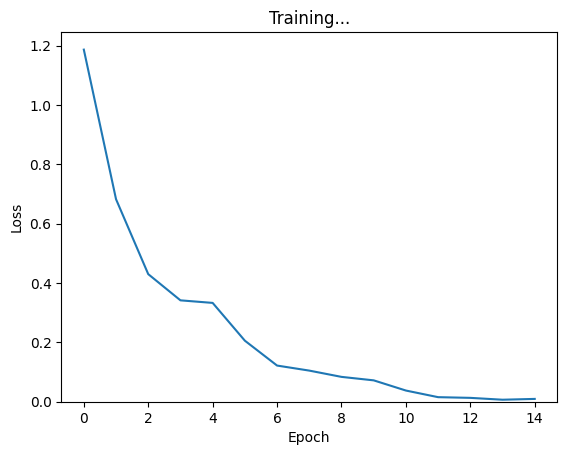

In [140]:
# Train function

from realtime_graph import realtimeplot
import gc

epochresults = []

for epoch in range(epochs):
    
    running_loss = 0.0

    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        #-------------------------
        
        #forward pass
        outputs = myresnetmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        #memory management: free up space
        del inputs, labels, outputs 
        torch.cuda.empty_cache()
        gc.collect()

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epochresults.append(epoch_loss)

    realtimeplot(epochresults)

In [141]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        #-------------------------
        
        # calculate outputs by running images through the network
        outputs = myresnetmodel.forward (inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 98 %
